# Process and Plot _siextentn_ from CMIP6 historical experiments

## Introduction
This notebook describes how to download, process and plot northern hemisphere sea ice extent from CMIP6 historical experiments.  I only include the first ensemble member from each model.  An alternative approach would be to use all ensemble members and calculate the model ensemble mean for models with multiple ensembles.

Data are processed into a single `pandas DataFrame` and written to a csv file `siextentn.CMIP6.historical.csv`.  A plot is generated and saved as `siextentn.CMIP6.historical.png`.

## Data
I use model files downloaded from `esfg-node.llnl.gov`.  The archive can be searched and files downloaded using the ESGF Search RESTful API.  Search strings can be entered into a browser as a URL or performed using the `python` `requests` module.

An example search for `project=CMIP6`, `variable_id=siextentn`, `table_id=SImon`, `experiment_id=historical`, and `member_id=r1i1p1f1` (the first ensemble member) looks like.



A `wget` script can be generated and downloaded by copy and pasting the following URL into a browser. 

https://esgf-node.llnl.gov/esg-search/wget?limit=500&project=CMIP6&variable_id=siextentn&table_id=SImon&experiment_id=historical&member_id=r1i1p1f1

This automatically downloads a `wget` script.  See https://www.earthsystemcog.org/projects/cog/doc/wget for further details.

You will need an ESGF login and OpenID to get the data.  This is easily set up.

# Searching for data

I use the ESGF API to search for data.  

In [11]:
import glob
import os
import sys
import calendar
import itertools

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

sys.path.append('../cmip6')
import munge

DATADIR = '/home/apbarret/Data/CMIP6'  # Change this to the location in which you ran the wget script
VARIABLE = 'siextentn'

## Directory structure and processing
Data for each model are contained in one or more files.  The download script places are the files in the directory in which the script was run.  Running the following cell tidys things up placing files in a directory tree by `variable`, `table`, `model`, `experiment`, and `ensemble-member`.  

def clean_up_downloaded_files(datadir):
    '''Moves ESGF CMIP6 files into a directory structure'''
    filelist = glob.glob(os.path.join(datadir, '*.nc'))
    if filelist:
        for f in filelist:
            variable, table, model, experiment, member, grid, time_range = f.split('_')
            dirpath = os.path.join(datadir, variable, table, model, experiment, member)
            try:
                os.makedirs(dirpath)
            except FileExistsError:
                pass  # It is OK is directory path exists
            except:
                print('Unexpected error: ', sys.exc_info()[0])
                raise
            os.rename(f, os.path.join(dirpath, f))
    else:
        print(f'No files found in {datadir}: nothing to be done')
            
clean_up_downloaded_files(DATADIR)

Northern hemisphere sea ice extent files are time series of scalars; one data point represent sea ice extent in millions of square kilometers.  I use `xarray` to read files for a single model ensemble member.  These are then place in a `pandas DataFrame`.  To facilitate this, I generate a dictionary using `munge.generate_catalog` with models as keys and lists of files as values.  You can find details of the code in `../CMIP6/cmip6/munge.py`

In [10]:
historical_catalog = munge.generate_catalog('siextentn', 'SImon', 'historical', 'r1i1p1f1', datadir=DATADIR)
scenario_catalog = munge.generate_catalog('siextentn', 'SImon', 'ssp585', 'r1i1p1f1', datadir=DATADIR)

Next I read the models using `xarray`.  Some models (e.g. CESM2) use a non-standard calendar with no leap year.  These data are y xarray as `CFTimeIndex` object.  To facilitate plotting and allow data to be combined, I convert `time` indices from `CFTimeIndex` to `datetime64`.  Time series are then concatenated into a `pandas` `DataFrame`.  The time conversion may not be necessary but I get errors when trying to plot using `xarray.DataFrame.siextentn.plot()`.  Timestamps for each month vary between models.  Some models use day 15 of a month as the central date, others use day 16.  When time series are concatenated into a single table, dates do not line up. So I use a helper function `_normalize_datetime` to set timestamps for all time steps to day 15 of each month.  These tools are in `munge.py`.

The `pandas` `Dataframe` containing all models is written to a `csv` file.

def read_ensemble(model):
    '''Reads file for a given model ensemble into an xarray Dataset'''
    ds = xr.open_mfdataset(catalog[model], combine='by_coords')
    if isinstance(ds.indexes['time'], xr.CFTimeIndex):
        ds['time'] = ds.indexes['time'].to_datetimeindex()
    return ds


def _normalize_datetime(TimeIndex):
    import datetime as dt
    return [dt.datetime(y, m, 15) for y, m in zip(ts.index.year, ts.index.month)]


def dataset2timeseries(ds):
    '''Converts ds.siextent to a pandas timeseries.  Times are set to midnight 00:00:00'''
    ts = ds.siextentn.squeeze().to_series()
    ts.index = _normalize_datetime(ts.index)
    return ts
    

In [12]:
import warnings
warnings.simplefilter("ignore")  # Brute force way to ignore RuntimeWarning about converting from noleap calendar

series = []
for model, filelist in catalog.items():
    ds = munge.read_ensemble(filelist)
    ts = munge.dataset2timeseries(ds[VARIABLE])
    ts.name = model
    series.append(ts)
warnings.simplefilter("default")  # Turn warnings back on

df = pd.concat(series, axis=1)
#df.to_csv(os.path.join(DATADIR, 'siextentn', 'SImon', 'siextentn.SImon.CMIP6.historical.csv'))
df.head()

,MPI-ESM1-2-HR,ACCESS-CM2,INM-CM4-8,CESM2-WACCM-FV2,MPI-ESM-1-2-HAM,CESM2-WACCM,ACCESS-ESM1-5,MRI-ESM2-0,AWI-CM-1-1-MR,CESM2-FV2,CESM2,MPI-ESM1-2-LR,INM-CM5-0,NorESM2-LM,NorESM2-MM,IPSL-CM6A-LR
1850-01-15,14.524994,15.400951,16.555944,14.800295,13.759284,14.373685,14.901051,14.435524,15.848625,14.464868,14.361740,15.367842,16.584423,14.099590,14.148132,16.124708
1850-02-15,15.057966,16.383898,17.993713,15.304046,14.711484,14.819675,15.802239,15.492135,17.196268,14.896288,15.053535,16.449190,17.948383,14.428174,14.753365,17.646687
1850-03-15,15.522406,17.105118,18.558460,15.387679,15.301144,15.225739,16.476192,15.889923,17.148649,15.399905,15.573739,16.917143,19.090279,14.314548,14.805148,17.595329
1850-04-15,15.146090,16.801937,18.207396,15.451011,14.589539,15.264583,16.144020,15.126458,16.392406,15.327523,15.279046,16.015171,18.509251,13.895150,14.015628,16.752907
1850-05-15,13.729387,15.766763,16.393532,14.638363,13.233748,14.512105,15.310038,13.832352,14.708080,14.551849,14.347973,13.972161,16.096630,12.263137,12.435895,14.313114


The `csv` file is read using `pandas.read_csv` as follows.

In [13]:
historical_df = pd.read_csv(os.path.join(DATADIR, 'siextentn', 'SImon', 'siextentn.SImon.CMIP6.historical.csv'),
                 index_col=0, header=0, parse_dates=True)
historical_df.head()

,MPI-ESM1-2-HR,ACCESS-CM2,INM-CM4-8,CESM2-WACCM-FV2,MPI-ESM-1-2-HAM,CESM2-WACCM,ACCESS-ESM1-5,MRI-ESM2-0,AWI-CM-1-1-MR,CESM2-FV2,CESM2,MPI-ESM1-2-LR,INM-CM5-0,NorESM2-LM,NorESM2-MM,IPSL-CM6A-LR
1850-01-15,14.524994,15.400951,16.555944,14.800295,13.759284,14.373685,14.901051,14.435524,15.848625,14.464868,14.361740,15.367842,16.584423,14.099590,14.148132,16.124708
1850-02-15,15.057966,16.383898,17.993713,15.304046,14.711484,14.819675,15.802239,15.492135,17.196268,14.896288,15.053534,16.449190,17.948383,14.428174,14.753365,17.646687
1850-03-15,15.522406,17.105118,18.558460,15.387679,15.301144,15.225739,16.476192,15.889923,17.148650,15.399905,15.573739,16.917143,19.090279,14.314548,14.805148,17.595330
1850-04-15,15.146090,16.801937,18.207396,15.451011,14.589539,15.264583,16.144020,15.126458,16.392406,15.327523,15.279046,16.015171,18.509250,13.895150,14.015628,16.752907
1850-05-15,13.729387,15.766763,16.393532,14.638363,13.233748,14.512105,15.310038,13.832352,14.708080,14.551849,14.347973,13.972161,16.096630,12.263137,12.435895,14.313114


Using the same command, we can read data for scenario SSP5-8.5

In [14]:
scenario_df = pd.read_csv(os.path.join(DATADIR, 'siextentn', 'SImon', 'siextentn.SImon.CMIP6.ssp585.csv'),
                          index_col=0, header=0, parse_dates=True)
scenario_df.head()

,MPI-ESM1-2-HR,ACCESS-CM2,INM-CM4-8,CESM2-WACCM,ACCESS-ESM1-5,MRI-ESM2-0,CESM2,MPI-ESM1-2-LR,INM-CM5-0,NorESM2-LM,NorESM2-MM,IPSL-CM6A-LR
2015-01-15,12.789171,14.268513,15.916616,13.500623,12.760018,12.780930,13.638623,13.275437,14.925991,12.891520,13.247250,13.648350
2015-02-15,13.921587,15.485116,17.320023,14.209235,13.789648,13.596770,14.098115,14.181568,16.146130,13.445102,13.958223,15.029686
2015-03-15,14.183046,15.712774,18.417587,14.565126,14.305043,13.811734,14.420953,14.334653,16.592552,13.439457,14.063489,15.348416
2015-04-15,13.861711,15.647352,18.472666,14.488211,14.257958,13.413544,14.379373,13.551353,15.894596,12.548750,13.248611,14.709952
2015-05-15,12.687566,14.780701,16.883186,13.624412,13.333877,12.084980,13.638932,12.196349,13.967101,10.943253,11.635010,12.803818


Not all models with _historical_ runs available have _ssp585_ runs.  These models can be compared as follows: 

In [33]:
hist_set = set(historical_df.columns)
scen_set = set(scenario_df.columns)
joint_set = hist_set.intersection(scen_set)
print(f"{len(joint_set)} models have data for historical and SSP5-8.5 experiments.")
print(f"These models are {', '.join(joint_set)}.")

12 models have data for historical and SSP5-8.5 experiments.
These models are INM-CM5-0, MPI-ESM1-2-LR, MRI-ESM2-0, IPSL-CM6A-LR, CESM2, ACCESS-CM2, MPI-ESM1-2-HR, NorESM2-LM, NorESM2-MM, ACCESS-ESM1-5, INM-CM4-8, CESM2-WACCM.


`historical_df` and `scenario_df` can be concatenated using `pd.concat`.  `.dropna` removes models that do not have data for SSP5-8.5.

In [45]:
concat_df = pd.concat([historical_df, scenario_df]).dropna(axis=1)

A "quick and dirty" plot of northern hemisphere September sea ice extent is made. 

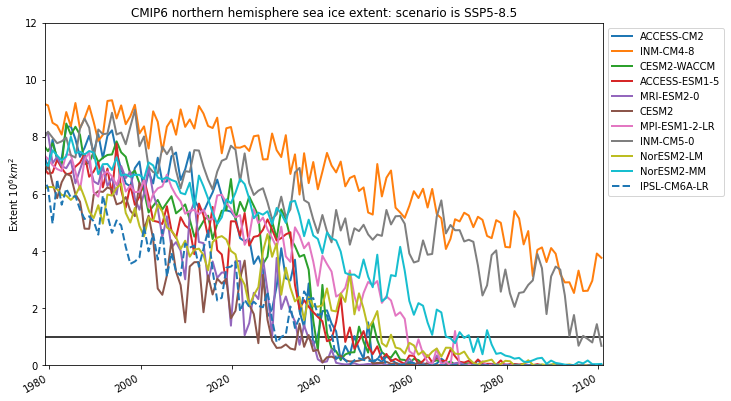

In [47]:
# Make color and symbols for models
it = itertools.product(['-', '--'], mcolors.TABLEAU_COLORS)
style, color = zip(*[next(it) for i in range(df.shape[1])])

fig, ax = plt.subplots(figsize=(10, 7))
concat_df[concat_df.index.month == 9].plot(ax = ax, linewidth=2, style=list(style), color=list(color))
ax.set_ylim(0, 12)
ax.set_xlim('1979-01-01', '2100-12-31');
ax.set_title("CMIP6 northern hemisphere sea ice extent: scenario is SSP5-8.5")
ax.set_ylabel("Extent $10^6 km^2$");
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
ax.axhline(1., c='k', zorder=1)
fig.savefig(os.path.join(DATADIR, 'siextentn', 'SImon', 'siextentn.SImon.CMIP6.historical_and_ssp585.png'))

The mean seasonal cycle of sea ice extent for 1979 to 2014 is show below.

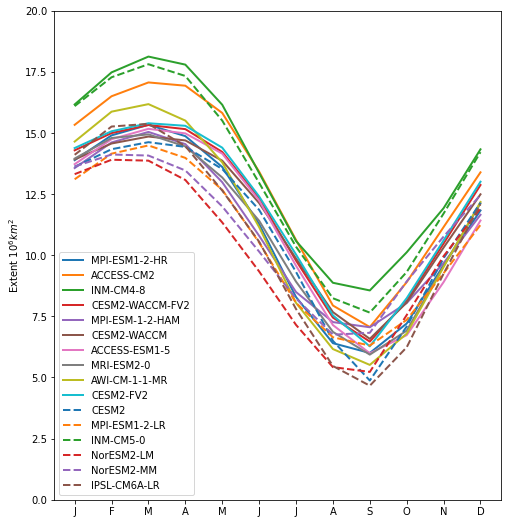

In [38]:
dfClim = historical_df['1979':'2014'].groupby(historical_df['1979':'2014'].index.month).mean()
fig, ax = plt.subplots(figsize=(8,9))
dfClim.plot(ax=ax, linewidth=2, style=list(style), color=list(color))
ax.set_ylim(0, 20)
ax.set_ylabel("Extent $10^6 km^2$")
ax.set_xticks(range(1,13))
ax.set_xticklabels([m[0] for m in calendar.month_abbr if len(m) > 0]);